# Assignment Two:  Sentiment Classification

For this exercise you will be using the "SemEval 2017 task 4" corpus provided on the module website, available through the following link: https://warwick.ac.uk/fac/sci/dcs/teaching/material/cs918/semeval-tweets.tar.bz2 You will focus particularly on Subtask A, i.e. classifying the overall sentiment of a tweet as positive, negative or neutral.

You are requested to produce a Jupyter notebook for the coursework submission. The input to your program is the SemEval data downloaded. Note that TAs need to run your program on their own machine by using the original SemEval data. As such, don’t submit a Python program that takes as input some preprocessed files.

In [68]:
# Skeleton: Evaluation code for the test sets
def read_test(testset):
    '''
    readin the testset and return a dictionary
    :param testset: str, the file name of the testset to compare
    '''
    id_gts = {}
    with open(testset, 'r', encoding='utf8') as fh:
        for line in fh:
            fields = line.split('\t')
            tweetid = fields[0]
            gt = fields[1]
            id_gts[tweetid] = gt

    return id_gts


def confusion(id_preds, testset, classifier):
    '''
    print the confusion matrix of {'positive', 'netative'} between preds and testset
    :param id_preds: a dictionary of predictions formated as {<tweetid>:<sentiment>, ... }
    :param testset: str, the file name of the testset to compare
    :classifier: str, the name of the classifier
    '''
    id_gts = read_test(testset)

    gts = []
    for m, c1 in id_gts.items():
        if c1 not in gts:
            gts.append(c1)

    gts = ['positive', 'negative', 'neutral']

    conf = {}
    for c1 in gts:
        conf[c1] = {}
        for c2 in gts:
            conf[c1][c2] = 0

    for tweetid, gt in id_gts.items():
        if tweetid in id_preds:
            pred = id_preds[tweetid]
        else:
            pred = 'neutral'
        conf[pred][gt] += 1

    print(''.ljust(12) + '  '.join(gts))

    for c1 in gts:
        print(c1.ljust(12), end='')
        for c2 in gts:
            if sum(conf[c1].values()) > 0:
                print('%.3f     ' % (conf[c1][c2] / float(sum(conf[c1].values()))), end='')
            else:
                print('0.000     ', end='')
        print('')

    print('')



def evaluate(id_preds, testset, classifier):
    '''
    print the macro-F1 score of {'positive', 'netative'} between preds and testset
    :param id_preds: a dictionary of predictions formated as {<tweetid>:<sentiment>, ... }
    :param testset: str, the file name of the testset to compare
    :classifier: str, the name of the classifier
    '''
    id_gts = read_test(testset)

    acc_by_class = {}
    for gt in ['positive', 'negative', 'neutral']:
        acc_by_class[gt] = {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0}

    catf1s = {}

    ok = 0
    for tweetid, gt in id_gts.items():
        if tweetid in id_preds:
            pred = id_preds[tweetid]
        else:
            print("do not find " + tweetid)
            pred = 'neutral'

        if gt == pred:
            ok += 1
            acc_by_class[gt]['tp'] += 1
        else:
            acc_by_class[gt]['fn'] += 1
            acc_by_class[pred]['fp'] += 1
    catcount = 0
    itemcount = 0
    macro = {'p': 0, 'r': 0, 'f1': 0}
    micro = {'p': 0, 'r': 0, 'f1': 0}
    semevalmacro = {'p': 0, 'r': 0, 'f1': 0}

    microtp = 0
    microfp = 0
    microtn = 0
    microfn = 0
    for cat, acc in acc_by_class.items():
        catcount += 1

        microtp += acc['tp']
        microfp += acc['fp']
        microtn += acc['tn']
        microfn += acc['fn']

        p = 0
        if (acc['tp'] + acc['fp']) > 0:
            p = float(acc['tp']) / (acc['tp'] + acc['fp'])

        r = 0
        if (acc['tp'] + acc['fn']) > 0:
            r = float(acc['tp']) / (acc['tp'] + acc['fn'])

        f1 = 0
        if (p + r) > 0:
            f1 = 2 * p * r / (p + r)

        catf1s[cat] = f1

        n = acc['tp'] + acc['fn']

        macro['p'] += p
        macro['r'] += r
        macro['f1'] += f1

        if cat in ['positive', 'negative']:
            semevalmacro['p'] += p
            semevalmacro['r'] += r
            semevalmacro['f1'] += f1

        itemcount += n

    micro['p'] = float(microtp) / float(microtp + microfp)
    micro['r'] = float(microtp) / float(microtp + microfn)
    micro['f1'] = 2 * float(micro['p']) * micro['r'] / float(micro['p'] + micro['r'])

    semevalmacrof1 = semevalmacro['f1'] / 2

    print(testset + ' (' + classifier + '): %.3f' % semevalmacrof1)

#### Import necessary packages

In [69]:
# Import necessary packages
import re
from os.path import join
import numpy as np
import nltk
import pandas as pd
import jsonlines
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
from sklearn.model_selection import GridSearchCV
from nltk.classify import NaiveBayesClassifier
from nltk.classify import accuracy as nltk_accuracy
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import emoji
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from gensim.models import KeyedVectors
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.naive_bayes import BernoulliNB
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from torch.optim import Adam
import matplotlib.pyplot as plt
import pickle

In [70]:
# Define test sets
testsets = ['twitter-test1.txt', 'twitter-test2.txt', 'twitter-test3.txt']


In [71]:
# Skeleton: Evaluation code for the test sets
def read_data(testset):
    '''
    readin the testset and return a dictionary
    :param testset: str, the file name of the testset to compare
    '''
    id=[]
    sentiment=[]
    tweet=[]
    with open(testset, 'r', encoding='utf8') as fh:
        for line in fh:
            fields = line.split('\t')
            id.append (fields[0])
            sentiment.append (fields[1])
            tweet.append (fields[2])
    df = pd.DataFrame({'tweetid': id, 'sentiment': sentiment, 'tweet': tweet})

    return df


#### Load training set, dev set and testing set
Here, you need to load the training set, the development set and the test set. For better classification results, you may need to preprocess tweets before sending them to the classifiers.

In [72]:
# Load training set, dev set and testing set
trainset = {}
devset = {}
testset1 = {}
testset2 = {}
testset3 = {}
trainset=read_data("twitter-training-data.txt")
devset=read_data("twitter-dev-data.txt")
testset1=read_data("twitter-test1.txt")
testset2=read_data("twitter-test2.txt")
testset3=read_data("twitter-test3.txt")


In [73]:
def get_dataset_distribution(dataset):

    num_negative = (dataset['sentiment'] == 'negative').sum()
    num_positive = (dataset['sentiment'] == 'positive').sum()
    num_neutral = (dataset['sentiment'] == 'neutral').sum()
    list=[num_negative,num_positive,num_neutral]
    return list
trainset_distribution=get_dataset_distribution(trainset)
devset_distribution=get_dataset_distribution(devset)
testset1_distribution=get_dataset_distribution(testset1)
testset2_distribution=get_dataset_distribution(testset2)
testset3_distribution=get_dataset_distribution(testset3)
distribution=[trainset_distribution,devset_distribution,testset1_distribution,testset2_distribution,testset3_distribution]
title=['trainset','devset','testset1','testset2','testset3']

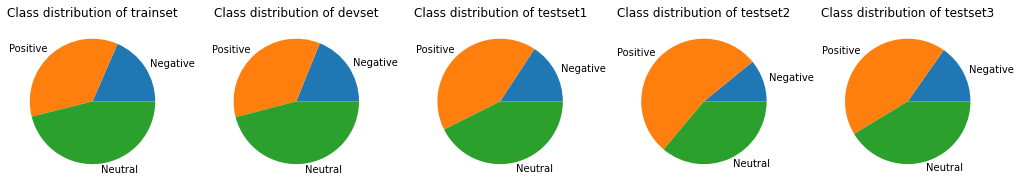

In [74]:
# Pie chart with category distribution
# Pie chart labels
labels = ['Negative', 'Positive', 'Neutral']

# Create 5 subplots
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

# Plot each sub diagram
for i in range(5):
    data = distribution[i]
    axs[i].pie(data, labels=labels)
    axs[i].set_title(f'Class distribution of {title[i]}')

# Adjust the spacing and margins between subplots
plt.subplots_adjust(wspace=0.3, left=0.05, right=0.95)

plt.show()

数据平衡

In [75]:
# Calculate the number of samples to be deleted
num_to_remove = 5000

# Get the index of all samples whose sentiment is neutral
negative_idx = trainset[trainset['sentiment'] == 'neutral'].index

# Randomly selected index of num_to_remove samples
remove_idx = np.random.choice(negative_idx, size=num_to_remove, replace=False)

 # Delete the selected sample
balanced_trainset=trainset.drop(remove_idx)

In [76]:
train_label=[trainset.iloc[index]["sentiment"] for index in range(len(trainset))]
balanced_train_label=[balanced_trainset.iloc[index]["sentiment"] for index in range(len(balanced_trainset))]
dev_label=[devset.iloc[index]["sentiment"] for index in range(len(devset))]
test1_label=[testset1.iloc[index]["sentiment"] for index in range(len(testset1))]
test2_label=[testset2.iloc[index]["sentiment"] for index in range(len(testset2))]
test3_label=[testset3.iloc[index]["sentiment"] for index in range(len(testset3))]

### Tokenization and Lemmatization

In [77]:
# First need to download the required data package
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
# List of deactivated words
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hongj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hongj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hongj\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hongj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [78]:
wnl = WordNetLemmatizer()

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
# Load the list of deactivated words
def lemmation(data):
    lemmatizer = WordNetLemmatizer()
    lemma =[]
    # Use Parts of speech (POS) to specify lexical properties
    tagged_sent = nltk.pos_tag(data)

    for tag in tagged_sent:
        wordnet_pos = get_wordnet_pos(tag[1]) or wordnet.NOUN
        lemma.append(wnl.lemmatize(tag[0], pos=wordnet_pos)) 
    return lemma

stop_words = set(stopwords.words('english'))

# Do not remove stop words
def clean_list(voca_list):
        # Use regular expressions to parse and clean up text
        for index in range(len(voca_list)):
                voca_list[index]=voca_list[index].lower()
        voca=[]
        for index in range(len(voca_list)):
                item=voca_list[index]
                # Clear all forms of URLs
                cleaned_text = re.sub(r'https?://\S+', '', item)
                # Turn emoji into text descriptions
                cleaned_text = emoji.demojize(cleaned_text)
                # Clear words of length 1
                cleaned_text = " ".join(re.findall(r'\b\w{2,}\b', cleaned_text))
                # Delete special characters
                cleaned_text = re.sub(r'[.\,\!\$\%\^&\*\(\)=\-_`~\+\{\}<>\?\:\;\'\"\[\]\|\@]', ' ', cleaned_text) # Delete special characters和表情符号
                # Splitting words
                cleaned_text = cleaned_text.split()
                # if len(cleaned_text)!=1:
                #   cleaned_text = [word for word in cleaned_text if word.lower() not in stop_words]
                cleaned_text = lemmation(cleaned_text)
                voca.append(cleaned_text)
        return(voca)    

def pre_process(data):
        # Get the "content" field, and put them in a new list
        voca_list=[]
        # content_list={}
        content_list=[]
        for index in range(data.shape[0]):
                voca_list.append(data.iloc[index]["tweet"])
                content_list.append(data.iloc[index]["tweet"])
        # Clean up the voca_list
        voca_list=clean_list(voca_list)
        content_list=clean_list(content_list)
        return content_list,voca_list

# Removal of deactivation
def clean_list1(voca_list):
        # Use regular expressions to parse and clean up text
        for index in range(len(voca_list)):
                voca_list[index]=voca_list[index].lower()
        voca=[]
        for index in range(len(voca_list)):
                item=voca_list[index]
                # Clear all forms of URLs
                cleaned_text = re.sub(r'https?://\S+', '', item)
                # Turn emoji into text descriptions
                cleaned_text = emoji.demojize(cleaned_text)
                # Clear words of length 1
                cleaned_text = " ".join(re.findall(r'\b\w{2,}\b', cleaned_text))
                # Delete special characters
                cleaned_text = re.sub(r'[.\,\!\$\%\^&\*\(\)=\-_`~\+\{\}<>\?\:\;\'\"\[\]\|\@]', ' ', cleaned_text)
                # Splitting words
                cleaned_text = cleaned_text.split()
                if len(cleaned_text)!=1:
# Deactivated words are words that occur frequently in text but usually do not carry an actual meaning, such as "a", "the", "of", etc. During text processing, these deactivated words are usually removed from the text in order to better extract useful information from the text.                  cleaned_text = [word for word in cleaned_text if word.lower() not in stop_words]
                    cleaned_text = lemmation(cleaned_text)
                voca.append(cleaned_text)
        return(voca)   
        

def pre_process1(data):
        # Get the "content" field, and put them in a new list
        voca_list=[]
        # content_list={}
        content_list=[]
        for index in range(data.shape[0]):
                voca_list.append(data.iloc[index]["tweet"])
                content_list.append(data.iloc[index]["tweet"])
        # Clean up the voca_list
        voca_list=clean_list1(voca_list)
        content_list=clean_list1(content_list)
        return content_list,voca_list
        

In [79]:
trainset_preprocessed,_ = pre_process(trainset)
balanced_trainset_preprocessed,vocabulary = pre_process(balanced_trainset)
devset_preprocessed,_ = pre_process(devset)
testset1_preprocessed,_ = pre_process(testset1)
testset2_preprocessed,_ = pre_process(testset2)
testset3_preprocessed,_ = pre_process(testset3)

In [80]:
# trainset_preprocessed_stop,_ = pre_process1(trainset)
# balanced_trainset_preprocessed_stop,vocabulary_stop = pre_process1(balanced_trainset)
# devset_preprocessed_stop,_ = pre_process1(devset)
# testset1_preprocessed_stop,_ = pre_process1(testset1)
# testset2_preprocessed_stop,_ = pre_process1(testset2)
# testset3_preprocessed_stop,_ = pre_process1(testset3)

### Naive Bayesian classifier

In [81]:
# wnl = WordNetLemmatizer()
# lemmas_sent_orginal = []
# # [privilege,.....,....]
# lemmas_sent_list_orginal=[]
# # [('aaqibafzaal', 'JJ'), ('pakistan', 'NN'), ('may', 'MD'), ('be', 'VB'), ('an', 'DT'), ('islamic', 'JJ'), ('country', 'NN'), ('but', 'CC'), ('der', 'NN'), ('are', 'VBP'), ('lot', 'VBN'), ('true', 'JJ'), ('muslims', 'NNS'), ('in', 'IN'), ('india', 'NN'), ('who', 'WP'), ('love', 'VBP'), ('their', 'PRP$'), ('country', 'NN'), ('and', 'CC'), ('can', 'MD'), ('sacrifice', 'VB'), ('all', 'DT'), ('for', 'IN'), ('it', 'PRP')]
# for tokens in vocabulary:
#     # 使用Parts of speech（POS）指定词性
#     tagged_sent = nltk.pos_tag(tokens)

#     for tag in tagged_sent:
#         wordnet_pos = get_wordnet_pos(tag[1]) or wordnet.NOUN
#         lemmas_sent_orginal.append(wnl.lemmatize(tag[0], pos=wordnet_pos)) # 词形还原
    
#     lemmas_sent_list_orginal.append(tagged_sent)
# print(len(lemmas_sent_orginal))
# lemmas_sent=lemmas_sent_orginal[:5000]
# lemmas_sent_list=lemmas_sent_list_orginal[:5000]

创建一个词汇表，并将数据集中的所有单词按照相同的顺序添加到词汇表中：

In [82]:
# # Splitting words
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(lemmas_sent)
# count_lemma = tokenizer.word_index

处理训练集和验证集

<!-- 特征提取: TF-IDF -->

在文本分类任务中，我们通常将一个单词作为一个特征，如果这个单词出现在文本中，我们就认为这个特征出现了。例如，如果我们以单词为特征，将一个句子 "The quick brown fox jumps over the lazy dog" 分解成单词，那么这个句子就包含了若干个特征，比如 "The"、"quick"、"brown"、"fox" 等等。如果某个单词出现在文本中，那么对应的特征就被标记为 True，否则为 False，这个特征向量就作为分类器的输入。

在朴素贝叶斯分类器中，每个特征都被视为独立的条件概率，因此只要某个特征出现在文本中，就可以对该特征进行概率计算，用于分类预测。

In [83]:

# # # 将每个实例转换成一个特征向量
# # # 定义特征提取函数
# def get_features(document):
#     features = {}
#     for word, i in count_lemma.items():
#         features[word] = (word in document)
#     return features


# def get_features_naive_bays(dataset):
#     dataset_features = []
#     for index in range(len(dataset)):
#         tokens = dataset[index]
#         # tokens = nltk.word_tokenize(dataset[index])
#         context = get_features(tokens)
#         label = trainset.iloc[index]["sentiment"]
#         dataset_features.append((context, label))
#     return dataset_features


# train_features = get_features_naive_bays(trainset_preprocessed)
# balanced_train_features = get_features_naive_bays(balanced_trainset_preprocessed)
# dev_features = get_features_naive_bays(devset_preprocessed)
# test1_features = get_features_naive_bays(testset1_preprocessed)
# test2_features = get_features_naive_bays(testset2_preprocessed)
# test3_features = get_features_naive_bays(testset3_preprocessed)



In [84]:
# # 训练NaiveBayesClassifier模型
# # 会报错 TypeError: init() missing 2 required positional arguments: 'label_probdist' and 'feature_probdist'，是因为 nltk.NaiveBayesClassifier() 构造函数需要 label_probdist 和 feature_probdist 两个必需的参数，这两个参数分别表示标签和特征的概率分布。
# # 相反，使用 classifier = NaiveBayesClassifier.train(train_features) 不会报错是因为 train 是一个静态方法，可以直接从类中调用。在这种情况下，首先会创建一个 NaiveBayesClassifier 对象，然后调用 train 方法来训练分类器，该方法需要一个特征列表 train_features 作为参数。在训练过程中，train 方法将自动估计标签和特征的概率分布，并将它们作为参数传递给 NaiveBayesClassifier 的构造函数。因此，在使用 train 方法时，不需要手动指定 label_probdist 和 feature_probdist 参数。
# classifier = NaiveBayesClassifier.train(balanced_train_features)
# # 模型评估
# print('Accuracy:', nltk_accuracy(classifier, dev_features))

In [85]:
# def get_naive_result(classifier,features,df,path):
#     dic_result={}
#     for index in range(len(features)):
#         index_d=df.iloc[index]["tweetid"]
#         dic_result[index_d]=classifier.classify(features[index][0])
#     # dic_result = {str(k): v for k, v in dic_result.items()}
#     evaluate(dic_result, path, "Naive Bayes Classifier")
#     confusion(dic_result, path, "Naive Bayes Classifier")

In [86]:
# get_naive_result(classifier,test1_features,testset1, "twitter-test1.txt")
# get_naive_result(classifier,test2_features,testset2,"twitter-test2.txt")
# get_naive_result(classifier,test3_features,testset3,"twitter-test3.txt")

**Before data balancing**

twitter-test1.txt (BernoulliNB): 0.419

            positive  negative  neutral

positive    0.670     0.088     0.242  

negative    0.151     0.634     0.215 

neutral     0.251     0.184     0.565     

twitter-test2.txt (BernoulliNB): 0.430

            positive  negative  neutral

positive    0.711     0.078     0.211   

negative    0.071     0.607     0.321   

neutral     0.332     0.129     0.539     

twitter-test3.txt (BernoulliNB): 0.434

            positive  negative  neutral

positive    0.679     0.093     0.227     

negative    0.175     0.598     0.227     

neutral     0.304     0.158     0.538   

**After data balancing**

twitter-test1.txt (Naive Bayes Classifier): 0.528

            positive  negative  neutral

positive    0.562     0.095     0.343     

negative    0.206     0.487     0.307   

neutral     0.230     0.152     0.618     


twitter-test2.txt (Naive Bayes Classifier): 0.520

            positive  negative  neutral

positive    0.625     0.076     0.299     

negative    0.232     0.432     0.336     

neutral     0.336     0.114     0.550     


twitter-test3.txt (Naive Bayes Classifier): 0.529

            positive  negative  neutral

positive    0.602     0.090     0.308     

negative    0.261     0.441     0.298     

neutral     0.269     0.131     0.600     




### BernoulliNB

The data set is vectorised and the processed data set is used in both BernoulliNB and SVC models

The TfidfVectorizer represents text as a document-word-item matrix, where each row represents a text and each column represents a word-item. Each element represents the tf-idf value of the lexical item in that text. The text data is transformed into a vectorised representation using the fit_transform function. Because of the large number of texts in an instance, the TfidfVectorizer here is initialised with max_features set to 3000 and min_df set to 5. max_features indicates the maximum number of features allowed to be extracted during the training process, and min_df indicates the minimum document frequency of word occurrences in the vocabulary.

In [87]:
# Vectorisation of text
vectorizer = TfidfVectorizer(max_features=3000, min_df=5)

trainset_preprocessed_new_2000 = [' '.join(text) for text in trainset_preprocessed]
X_1000 = vectorizer.fit_transform(trainset_preprocessed_new_2000)
devset_preprocessed_new_2000 = [' '.join(text) for text in devset_preprocessed]
dev_X_1000 = vectorizer.transform(devset_preprocessed_new_2000)
testset1_preprocessed_new_2000 = [' '.join(text) for text in testset1_preprocessed]
test1_X_1000=vectorizer.transform(testset1_preprocessed_new_2000)
testset2_preprocessed_new_2000 = [' '.join(text) for text in testset2_preprocessed]
test2_X_1000=vectorizer.transform(testset2_preprocessed_new_2000)
testset3_preprocessed_new_2000 = [' '.join(text) for text in testset3_preprocessed]
test3_X_1000=vectorizer.transform(testset3_preprocessed_new_2000)

print("Build a vectorizer!")

Build a vectorizer!


Finding the optimal combination of parameters

In [88]:

# model = BernoulliNB()
# param_grid = {
#     'alpha': [0.1, 1.0, 10.0,100],
#     'fit_prior': [True, False],
#     'class_prior': [None, [0.3, 0.7], [0.4, 0.6]]
# }

# grid_search = GridSearchCV(model, param_grid, cv=5)
# grid_search.fit(X, train_label)

# print('Best params:', grid_search.best_params_)
# print('Best score:', grid_search.best_score_)


Best params: {'alpha': 10.0, 'class_prior': None, 'fit_prior': True}
Best score: 0.6234396071075079

In [89]:
# Model training
BernoulliNB_classifier = BernoulliNB(alpha= 10.0, class_prior= None, fit_prior= True)
BernoulliNB_classifier.fit(X_1000, train_label)

BernoulliNB(alpha=10.0)

In [90]:
# Print result
def get_BernoulliNB_result(classifier,dataset,df,path):
    dic_result={}
    BernoulliNB_classifier_result=classifier.predict(dataset)
    for index in range(len(BernoulliNB_classifier_result)):
        index_d=df.iloc[index]["tweetid"]
        dic_result[index_d]=BernoulliNB_classifier_result[index]
    dic_result = {str(k): v for k, v in dic_result.items()}
    evaluate(dic_result, path, "BernoulliNB")
    confusion(dic_result, path, "BernoulliNB")

In [91]:
dev_X_labels = BernoulliNB_classifier.predict(dev_X_1000)

# Printed model evaluation results
print("Test one")
print(classification_report(dev_X_labels,dev_label))

Test one
              precision    recall  f1-score   support

    negative       0.45      0.58      0.51       294
     neutral       0.67      0.63      0.65       986
    positive       0.66      0.64      0.65       720

    accuracy                           0.62      2000
   macro avg       0.59      0.62      0.60      2000
weighted avg       0.63      0.62      0.63      2000



In [92]:
get_BernoulliNB_result(BernoulliNB_classifier,test1_X_1000,testset1,"twitter-test1.txt")
get_BernoulliNB_result(BernoulliNB_classifier,test2_X_1000,testset2,"twitter-test2.txt")
get_BernoulliNB_result(BernoulliNB_classifier,test3_X_1000,testset3,"twitter-test3.txt")

twitter-test1.txt (BernoulliNB): 0.467
            positive  negative  neutral
positive    0.658     0.083     0.259     
negative    0.167     0.681     0.153     
neutral     0.254     0.175     0.571     

twitter-test2.txt (BernoulliNB): 0.478
            positive  negative  neutral
positive    0.716     0.077     0.207     
negative    0.082     0.592     0.327     
neutral     0.323     0.120     0.557     

twitter-test3.txt (BernoulliNB): 0.484
            positive  negative  neutral
positive    0.683     0.087     0.230     
negative    0.236     0.547     0.217     
neutral     0.292     0.149     0.559     



### SVM



Finding the optimal parameters based on half of the data because the training set is too large

In [93]:
# para_train_label=train_label[:len(train_label)//2]
# X_half = X[:X.shape[0]//2, :]

In [94]:
# from sklearn.model_selection import GridSearchCV

# model_svc = SVC()

# # Set the list of parameters to be optimised
# param_grid = {
#     "kernel": ['poly', "linear", 'rbf']
# }

# # Cross-validation of models using GridSearchCV
# grid_search = GridSearchCV(model_svc, param_grid, scoring='f1', cv=5)
# grid_search.fit(X_half, para_train_label)

# # Print optimal parameters
# print("Best parameters: ", grid_search.best_params_)

Best parameters:  {'kernel': 'poly'}


In [95]:
# # Training SVM models
# model = SVC(kernel='poly')
# model.fit(X_1000, train_label)

# print("Train a model!")

# # Predictions on the test set
# predictions = model.predict(dev_X_1000)

# # Printed model evaluation results
# print(classification_report(dev_label,predictions))

In [96]:
# import pickle
# model = SVC(kernel='rbf')
# # Save the model as a .pth file
# with open('SVC_model.pkl', 'wb') as f:
#     pickle.dump(model, f)

In [97]:
def get_SVC_result(model,features,df):
    dic_result={}
    for index in range(features.shape[0]):
        index_d=df.iloc[index]["tweetid"]
        # Convert the index in an array to a string type
        dic_result[str(index_d)]=model.predict(features[index][0])[0]
        
        # break
    return dic_result

In [98]:
# dev_pred=get_SVC_result(model,dev_X_1000,devset)
# evaluate(dev_pred, "twitter-dev-data.txt", "SVM")
# confusion(dev_pred, "twitter-dev-data.txt", "SVM")

# test1_pred=get_SVC_result(model,test1_X_1000,testset1)
# evaluate(test1_pred, "twitter-test1.txt", "SVM")
# confusion(test1_pred, "twitter-test1.txt", "SVM")

# test2_pred=get_SVC_result(model,test2_X_1000,testset2)
# evaluate(test2_pred, "twitter-test2.txt", "SVM")
# confusion(test2_pred, "twitter-test2.txt", "SVM")

# test3_pred=get_SVC_result(model,test3_X_1000,testset3)
# evaluate(test3_pred, "twitter-test3.txt", "SVM")
# confusion(test3_pred, "twitter-test3.txt", "SVM")

In [99]:
with open('./model/SVC_model.pkl', 'rb') as f:
    model = pickle.load(f)
    dev_pred=get_SVC_result(model,dev_X_1000,devset)
    evaluate(dev_pred, "twitter-dev-data.txt", "SVM")
    confusion(dev_pred, "twitter-dev-data.txt", "SVM")

    test1_pred=get_SVC_result(model,test1_X_1000,testset1)
    evaluate(test1_pred, "twitter-test1.txt", "SVM")
    confusion(test1_pred, "twitter-test1.txt", "SVM")

    test2_pred=get_SVC_result(model,test2_X_1000,testset2)
    evaluate(test2_pred, "twitter-test2.txt", "SVM")
    confusion(test2_pred, "twitter-test2.txt", "SVM")

    test3_pred=get_SVC_result(model,test3_X_1000,testset3)
    evaluate(test3_pred, "twitter-test3.txt", "SVM")
    confusion(test3_pred, "twitter-test3.txt", "SVM")

twitter-dev-data.txt (SVM): 0.424
            positive  negative  neutral
positive    0.761     0.042     0.197     
negative    0.047     0.812     0.141     
neutral     0.232     0.209     0.558     

twitter-test1.txt (SVM): 0.331
            positive  negative  neutral
positive    0.815     0.046     0.139     
negative    0.079     0.816     0.105     
neutral     0.310     0.180     0.511     

twitter-test2.txt (SVM): 0.363
            positive  negative  neutral
positive    0.841     0.041     0.117     
negative    0.000     0.917     0.083     
neutral     0.392     0.132     0.475     

twitter-test3.txt (SVM): 0.320
            positive  negative  neutral
positive    0.806     0.046     0.147     
negative    0.069     0.793     0.138     
neutral     0.341     0.171     0.488     



### Combining GloVe, LSTM to build a neural network

Handling data sets

In [100]:
# Open the original GloVe model file
with open('glove.6B.100d.txt', 'r', encoding='utf8') as f:
    lines = f.readlines()

# Add vocabulary and vector size information to the first line of the file
lines.insert(0, '400000 100\n')

# Write the modified content to a new file
with open('glove.6B.100d.new.txt', 'w', encoding='utf8') as f:
    f.writelines(lines)

In [101]:
glove_file = 'glove.6B.100d.new.txt'
embedding_dict = {}
with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_dict[word] = vector
embedding_dim = len(embedding_dict['the'])

The size of embedding matrix is 5000*100

In [102]:

embedding_dim=100
def get_dataset_label_LSTM(dataset):
    label_list = dataset['sentiment'].values.tolist()
    label_list = [[1,0,0] if x == "positive" else x for x in label_list]
    label_list = [[0,1,0] if x == "negative" else x for x in label_list]
    label_list = [[0,0,1] if x == "neutral" else x for x in label_list]
    label_array = np.array(label_list)
    label_tensor = torch.tensor(label_array)
    return label_tensor

def get_test_label_LSTM(dataset):
    label_list = dataset['sentiment'].values.tolist()
    label_list = [0 if x == "positive" else x for x in label_list]
    label_list = [1 if x == "negative" else x for x in label_list]
    label_list = [2 if x == "neutral" else x for x in label_list]
    label_array = np.array(label_list)
    label_tensor = torch.tensor(label_array)
    return label_tensor

vocab_len=5000

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_len)
# tokenizer = tf.keras.preprocessing.text.Tokenizer()
def preprocess_data(data): 
    data_tokenized = []
    tokenizer.fit_on_texts(data)
    sequences = tokenizer.texts_to_sequences(data)

    # print(data_tokenized[0])
    sequences = pad_sequences(sequences, padding='pre', maxlen=15)
    sequences = torch.tensor(sequences)
    word_index = tokenizer.word_index
    return word_index,sequences,tokenizer
word_index, train_LSTM,tokenizer=preprocess_data(trainset_preprocessed)
# embedding_matrix = np.zeros((len(word_index)+1, embedding_dim),dtype="float32")
embedding_matrix = np.zeros((vocab_len, embedding_dim),dtype="float32")
miss=0
for word, i in word_index.items():
    if i<vocab_len:
        if word not in embedding_dict:
          embedding_matrix[i] = embedding_dict.get('unk')
          miss=miss+1
        else:
          embedding_matrix[i]= embedding_dict.get(word)

In [103]:
train_label_LSTM=get_dataset_label_LSTM(trainset)
dev_label_LSTM=get_test_label_LSTM(devset)
test1_label_LSTM=get_test_label_LSTM(testset1)
test2_label_LSTM=get_test_label_LSTM(testset2)
test3_label_LSTM=get_test_label_LSTM(testset3)

In [104]:
def preprocess_data_test(data,tokenizer):
  sequences = tokenizer.texts_to_sequences(data)
  sequences = pad_sequences(sequences, padding='pre', maxlen=15)
  sequences = torch.tensor(sequences)
  return sequences

In [105]:
dev_LSTM =preprocess_data_test(devset_preprocessed,tokenizer)
test1_LSTM =preprocess_data_test(testset1_preprocessed,tokenizer)
test2_LSTM =preprocess_data_test(testset2_preprocessed,tokenizer)
test3_LSTM =preprocess_data_test(testset3_preprocessed,tokenizer)

In [106]:
# shuffle indicates whether batches are randomly split
train_dataset = torch.utils.data.TensorDataset(train_LSTM, train_label_LSTM)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
dev_dataset = torch.utils.data.TensorDataset(dev_LSTM, dev_label_LSTM)
dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=4, shuffle=False)
test1_dataset = torch.utils.data.TensorDataset(test1_LSTM, test1_label_LSTM)
test1_dataloader = torch.utils.data.DataLoader(test1_dataset, batch_size=32, shuffle=True)
test2_dataset = torch.utils.data.TensorDataset(test2_LSTM, test2_label_LSTM)
test2_dataloader = torch.utils.data.DataLoader(test2_dataset, batch_size=32, shuffle=False)
test3_dataset = torch.utils.data.TensorDataset(test3_LSTM, test3_label_LSTM)
test3_dataloader = torch.utils.data.DataLoader(test3_dataset, batch_size=32, shuffle=False)

###  Define LSTM model's architecture with limited embedding_matrix

Embedding layer: Converts the output numeric vectors into a vector representation.

LSTM layer: Processes sequential data using LSTM to capture long-term dependencies.

Output layer: Converts the final output into a classification probability using the Linear function.

In [107]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the model
class SentimentAnalysisModel(nn.Module):
    def __init__(self, embedding_matrix,hidden_dim,dropout=0.2):
        # The initialisation method of the SentimentAnalysisModel class's parent class, nn.Module, is called to ensure that the model is correctly initialised. The purpose of this line of code is to ensure that the model can successfully inherit from the nn.Module class and can use the various methods and properties it defines.
        super(SentimentAnalysisModel, self).__init__()
        # Defining the embedding layer
        self.embedding_layer = nn.Embedding.from_pretrained(torch.from_numpy(embedding_matrix))
        self.embedding_layer.weight.requires_grad = False
        # Define the LSTM layer for extracting sequence features
        self.lstm = nn.LSTM(embedding_matrix.shape[1],hidden_size=hidden_dim,dropout=dropout,num_layers=2,bidirectional=True,batch_first=True)
        # Defining the fully connected layer
        self.fc = nn.Linear(hidden_dim*2, 3)
        
        
    def forward(self, input):

        embedding_input = self.embedding_layer(input)

        lstm_input, _ = self.lstm(embedding_input)

        lstm_input = lstm_input[:, -1, :]

        result = self.fc(lstm_input)

        return result

In [108]:
print(embedding_matrix.shape)

(5000, 100)


Loss Function and Optimizer

In [109]:

hidden_dum=128

 # Initialize the model, loss function, and optimizer
model = SentimentAnalysisModel(embedding_matrix,hidden_dum)
model.load_state_dict(torch.load('./model/best_lstm_500015.pth'))

epochs        = 30
learning_rate = 0.01

# Loss Function
loss_fn = nn.CrossEntropyLoss()
# class_weight = torch.tensor([1.0, 2.0, 0.5])
# loss_fn = nn.CrossEntropyLoss(weight=class_weight)

# Optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)

In [110]:
def get_RNN_result(classifier,datasent,df):
    dic_result={}
    for index in range(len(datasent)):
        index_d=df.iloc[index]["tweetid"]
        dic_result[index_d]=classifier.classify(datasent[index][0])
    return dic_result

def get_LSTM_result(result,df):
    dic_result={}
    for index in range(len(df)):
        index_d=df.iloc[index]["tweetid"]
        if result[index]==0:
          dic_result[index_d]="positive"
        elif result[index]==1:
          dic_result[index_d]="negative"
        else:
          dic_result[index_d]="neutral"
    return dic_result

#### Training and Validation Accuracy

In [111]:
# # Train the model
# accuracy_list=[]
# loss_list=[]
# for epoch in range(epochs):
#     model.train()
#     loss_sum=0
#     time=0

#     for i, (inputs, labels) in enumerate(train_dataloader):
        
#         # labels = torch.tensor(labels, dtype=torch.long)
#         optimizer.zero_grad()
        
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs.data, 1)
#         labels = labels.float()
#         loss = loss_fn(outputs, labels)
#         loss_sum=loss_sum+loss.item()
#         time=time+1
        
#         # print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, len(train_dataloader), loss.item()))
#         loss.backward()
#         optimizer.step()
#     print("average loss",loss_sum/ time)
#     loss_list.append(loss_sum/ time)
#     # Evaluate on the validation set
#     torch.save(model.state_dict(),"best_lstm_5000"+str(epoch)+".pth")
#     model.eval()
#     correct, total = 0, 0
#     dev_result=[]
#     with torch.no_grad():
#         for inputs, labels in dev_dataloader:
#             outputs = model(inputs)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             dev_result=dev_result+predicted.tolist()
#             correct += (predicted == labels).sum().item()
#     dev_result=get_LSTM_result(dev_result,devset)
#     # result
#     accuracy = 100 * correct / total
#     accuracy_list.append(accuracy)
#     print('Epoch [{}/{}], Validation Accuracy: {:.2f}%'.format(epoch+1, epochs, accuracy))
#     dev_result = {str(k): v for k, v in dev_result.items()}
    
#     evaluate(dev_result, "twitter-dev-data.txt", "LSTM")
#     confusion(dev_result, "twitter-dev-data.txt", "LSTM")

Epoch of 15 is optimal on devset, but Accuracy is not the highest at this time

Information is below:

average loss 0.6813841353071497

Epoch [15/30], Validation Accuracy: 62.80%

/content/gdrive/MyDrive/cw2/twitter-dev-data.txt (LSTM): 0.603

        positive  negative  neutral

positive    0.694     0.042     0.264

negative    0.091     0.559     0.350  

neutral     0.254     0.129     0.617  

In [112]:
LSTM_5000_accuracy_list=[62.4, 61.8, 61.95, 63.05, 63.65, 63.4, 63.65, 62.7, 64.65, 63.4, 64.95, 65.4, 63.35, 63.05, 63.5, 62.4, 62.75, 63.3, 65.05, 62.05, 61.95, 62.3, 63.0, 63.05, 62.85, 62.7, 62.6, 60.9, 62.2, 62.15]
LSTM_5000_loss_list=[0.8776119701828516, 0.8119358728540704, 0.7887103473675167, 0.7732360145513048, 0.7624857674253748, 0.7484373780852513, 0.7459094196980727, 0.7354550465413019, 0.7307149575534442, 0.7214169626540327, 0.718623747364849, 0.7121391821837594, 0.7119934441561394, 0.7058293274953855, 0.7006369074185689, 0.697806467908494, 0.7043842089302996, 0.7134368099430775, 0.7080781865627208, 0.7007945618730911, 0.6915238263547844, 0.6978334061431547, 0.702710811149144, 0.7026373802347387, 0.6971022814723616, 0.6948223270634387, 0.694922840468427, 0.7121027911174382, 0.7173728943927914, 0.7127624604718905]
LSTM_5000_F1_score=[0.483,0.552,0.558,0.576,0.580,0.584,0.575,0.592,0.577,0.583,0.601,0.602,0.601,0.550,0.603,0.550,0.591,0.554,0.597,0.598,0.566,0.567,0.601,0.575,0.582, 0.552,0.550,0.566,0.578, 0.552]

Test

In [113]:
# Test the model
model.eval()
correct, total = 0, 0
predicted_list = []
with torch.no_grad():
    for inputs, labels in test1_dataloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predicted_list.append(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(accuracy)

63.60804304729538


In [114]:
def test_LSTM_model(test1_dataloader,testset1,model):
  # Test the model
  model.eval()
  correct, total = 0, 0
  result=[]
  with torch.no_grad():
    for inputs, labels in test1_dataloader:
              outputs = model(inputs)
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              result=result+predicted.tolist()
              correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    test1_result=get_LSTM_result(result,testset1)
    
    print(accuracy)
    return test1_result,result

test1_result,result1=test_LSTM_model(test1_dataloader,testset1,model)
test2_result,result2=test_LSTM_model(test2_dataloader,testset2,model)
test3_result,result3=test_LSTM_model(test3_dataloader,testset3,model)

63.60804304729538
62.7630868861306
59.26860025220681


In [115]:
evaluate(test1_result, "twitter-test1.txt", "LSTM")
confusion(test1_result, "twitter-test1.txt", "LSTM")
evaluate(test2_result, "twitter-test2.txt", "LSTM")
confusion(test2_result, "twitter-test2.txt", "LSTM")
evaluate(test3_result, "twitter-test3.txt", "LSTM")
confusion(test3_result, "twitter-test3.txt", "LSTM")

twitter-test1.txt (LSTM): 0.239
            positive  negative  neutral
positive    0.392     0.160     0.449     
negative    0.382     0.178     0.440     
neutral     0.437     0.154     0.410     

twitter-test2.txt (LSTM): 0.531
            positive  negative  neutral
positive    0.743     0.057     0.199     
negative    0.221     0.589     0.189     
neutral     0.367     0.107     0.526     

twitter-test3.txt (LSTM): 0.501
            positive  negative  neutral
positive    0.689     0.085     0.226     
negative    0.194     0.523     0.284     
neutral     0.321     0.132     0.547     



###  Define LSTM model's architecture with non-limited embedding_matrix

In [116]:
import tensorflow as tf
import torch
embedding_dim=100

tokenizer = tf.keras.preprocessing.text.Tokenizer()

def preprocess_data(data): 
    data_tokenized = []
    tokenizer.fit_on_texts(data)
    sequences = tokenizer.texts_to_sequences(data)

    # print(data_tokenized[0])
    sequences = pad_sequences(sequences, padding='pre', maxlen=15)
    sequences = torch.tensor(sequences)
    word_index = tokenizer.word_index
    return word_index,sequences,tokenizer


word_index1, train_LSTM1,tokenizer1=preprocess_data(trainset_preprocessed)
embedding_matrix1 = np.zeros((len(word_index1)+1, embedding_dim),dtype="float32")

for word, i in word_index1.items():
        if word not in embedding_dict:
          embedding_matrix1[i] = embedding_dict.get('unk')
        else:
          embedding_matrix1[i]= embedding_dict.get(word)

In [117]:
print(embedding_matrix1.shape)

(51292, 100)


In [118]:
dev_LSTM1 =preprocess_data_test(devset_preprocessed,tokenizer1)
test1_LSTM1 =preprocess_data_test(testset1_preprocessed,tokenizer1)
test2_LSTM1 =preprocess_data_test(testset2_preprocessed,tokenizer1)
test3_LSTM1 =preprocess_data_test(testset3_preprocessed,tokenizer1)

In [119]:
train_dataset1 = torch.utils.data.TensorDataset(train_LSTM1, train_label_LSTM)
train_dataloader1 = torch.utils.data.DataLoader(train_dataset1, batch_size=32, shuffle=True)
dev_dataset1 = torch.utils.data.TensorDataset(dev_LSTM1, dev_label_LSTM)
dev_dataloader1 = torch.utils.data.DataLoader(dev_dataset1, batch_size=32, shuffle=False)
test1_dataset1 = torch.utils.data.TensorDataset(test1_LSTM1, test1_label_LSTM)
test1_dataloader1 = torch.utils.data.DataLoader(test1_dataset1, batch_size=32, shuffle=False)
test2_dataset1 = torch.utils.data.TensorDataset(test2_LSTM1, test2_label_LSTM)
test2_dataloader1 = torch.utils.data.DataLoader(test2_dataset1, batch_size=32, shuffle=False)
test3_dataset1 = torch.utils.data.TensorDataset(test3_LSTM1, test3_label_LSTM)
test3_dataloader1 = torch.utils.data.DataLoader(test3_dataset1, batch_size=32, shuffle=False)

In [120]:
# Define the model
class SentimentAnalysisModel_2(nn.Module):
    def __init__(self, embedding_matrix,hidden_dim,dropout=0.2):
        # The initialisation method of the SentimentAnalysisModel class's parent class, nn.Module, is called to ensure that the model is correctly initialised. The purpose of this line of code is to ensure that the model can successfully inherit from the nn.Module class and can use the various methods and properties it defines.
        super(SentimentAnalysisModel_2, self).__init__()
        # Defining the embedding layer
        self.embedding_layer = nn.Embedding.from_pretrained(torch.from_numpy(embedding_matrix))
        self.embedding_layer.weight.requires_grad = False
        # Define the LSTM layer for extracting sequence features
        self.lstm = nn.LSTM(embedding_matrix.shape[1],hidden_size=hidden_dim,dropout=dropout,num_layers=2,bidirectional=True,batch_first=True)
        # Defining the fully connected layer
        self.fc = nn.Linear(hidden_dim*2, 3)
        
        
    def forward(self, input):
        embedding_input = self.embedding_layer(input)
        lstm_input, _ = self.lstm(embedding_input)
        lstm_input = lstm_input[:, -1, :]
        result = self.fc(lstm_input)
        return result

In [121]:
hidden_dum=128

 # Initialize the model, loss function, and optimizer
model_2 = SentimentAnalysisModel_2(embedding_matrix1,hidden_dum)
model_2.load_state_dict(torch.load('./model/best_lstm_nolimited_17.pth'))
epochs        = 30
learning_rate = 0.01

# Loss Function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)

In [122]:
# # Train the model
# accuracy_list=[]
# loss_list=[]
# for epoch in range(epochs):
#     model.train()
#     loss_sum=0
#     time=0

#     for i, (inputs, labels) in enumerate(train_dataloader1):
        
#         # labels = torch.tensor(labels, dtype=torch.long)
#         optimizer.zero_grad()
        
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs.data, 1)
#         labels = labels.float()
#         loss = loss_fn(outputs, labels)
#         loss_sum=loss_sum+loss.item()
#         time=time+1
        
#         # print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, len(train_dataloader), loss.item()))
#         loss.backward()
#         optimizer.step()
#     print("average loss",loss_sum/ time)
#     loss_list.append(loss_sum/ time)
#     # Evaluate on the validation set
#     torch.save(model.state_dict(),"best_lstm_nolimited_"+str(epoch)+".pth")
#     model.eval()
#     correct, total = 0, 0
#     dev_result=[]
#     with torch.no_grad():
#         for inputs, labels in dev_dataloader1:
#             outputs = model(inputs)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             dev_result=dev_result+predicted.tolist()
#             correct += (predicted == labels).sum().item()
#     dev_result=get_LSTM_result(dev_result,devset)
#     # result
#     accuracy = 100 * correct / total
#     accuracy_list.append(accuracy)
#     print('Epoch [{}/{}], Validation Accuracy: {:.2f}%'.format(epoch+1, epochs, accuracy))
#     dev_result = {str(k): v for k, v in dev_result.items()}
    
#     evaluate(dev_result, "twitter-dev-data.txt", "LSTM")
#     confusion(dev_result, "twitter-dev-data.txt", "LSTM")

**Optimal results**

average loss 0.6747487826127533

Epoch [17/30], Validation Accuracy: 63.50%

/content/gdrive/MyDrive/cw2/twitter-dev-data.txt (LSTM): 0.608

            positive  negative  neutral

positive    438.000     29.000     182.000  

negative    27.000     204.000     109.000   

neutral     238.000     145.000     628.000     


In [123]:
LSTM_nonlimited_loss_list=[0.8725092326918392, 0.8057633484508975, 0.7821805955247676, 0.76335154336395, 0.7478578329086304, 0.733125728939442, 0.72381323432246, 0.7146362344212566, 0.7016217644332994, 0.6975348826418531, 0.6868466202460283, 0.685495617964589, 0.6808226977257018, 0.6766568929591077, 0.6725089657813945, 0.6693432959681707, 0.6747487826127533, 0.6669836447171286, 0.6637605224940794, 0.668379356083295, 0.6609375093211519, 0.6596252970238949, 0.6519322567374993, 0.6586275813427377, 0.6615035973753489, 0.6624661011053316, 0.6596654728372047, 0.6595572181838624, 0.6595044520307094, 0.6638959229626554]
LSTM_nonlimited_accuracy_list=[60.85, 61.65, 62.65, 61.45, 62.4, 62.55, 61.5, 62.5, 63.25, 63.25, 62.9, 61.65, 62.8, 62.25, 62.75, 62.95, 63.5, 63.45, 61.3, 62.85, 62.05, 63.25, 61.7, 62.25, 62.9, 62.7, 61.65, 61.9, 62.05, 62.75]
LSTM_nonlimited_F1_list=[0.555,0.581,0.584,0.528,0.567,0.552,0.594,0.603,0.586,0.593,0.587,0.569,0.589,0.577,0.595,0.578,0.608,0.595,0.563,0.596,0.577,0.588,0.576,0.587,0.572,0.559,0.598,0.590,0.570,0.581]

In [124]:
test1_result1,result1=test_LSTM_model(test1_dataloader1,testset1,model_2)
test2_result1,result2=test_LSTM_model(test2_dataloader1,testset2,model_2)
test3_result1,result3=test_LSTM_model(test3_dataloader1,testset3,model_2)

evaluate(test1_result1, "twitter-test1.txt", "LSTM")
confusion(test1_result1, "twitter-test1.txt", "LSTM")
evaluate(test2_result1, "twitter-test2.txt", "LSTM")
confusion(test2_result1, "twitter-test2.txt", "LSTM")
evaluate(test3_result1, "twitter-test3.txt", "LSTM")
confusion(test3_result1, "twitter-test3.txt", "LSTM")

63.35315774568111
60.55045871559633
59.394703656998736
twitter-test1.txt (LSTM): 0.547
            positive  negative  neutral
positive    0.754     0.050     0.195     
negative    0.193     0.573     0.234     
neutral     0.278     0.142     0.581     

twitter-test2.txt (LSTM): 0.550
            positive  negative  neutral
positive    0.754     0.046     0.200     
negative    0.190     0.629     0.181     
neutral     0.409     0.095     0.497     

twitter-test3.txt (LSTM): 0.527
            positive  negative  neutral
positive    0.720     0.063     0.217     
negative    0.191     0.515     0.294     
neutral     0.334     0.122     0.544     



### GRU（Gated Recurrent Unit）model with non-limited embedding matrix

In [125]:
# Define the model
class SentimentAnalysisTransferModel(nn.Module):
    def __init__(self, embedding_matrix,hidden_dim,bidirectional,n_layers,dropout=0.2,output_dim=3):
        super(SentimentAnalysisTransferModel, self).__init__()
        # Define the embedding layer
        self.embedding_layer = nn.Embedding.from_pretrained(torch.from_numpy(embedding_matrix))
        self.embedding_layer.weight.requires_grad = False

        # Define the GRU layer for extracting sequence features
        self.rnn = nn.GRU(embedding_matrix.shape[1],
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        # This line of code creates a dropout layer and stores it in self.dropout. If the number of GRU layers is less than 2, then dropout is not used.
        self.dropout = nn.Dropout(dropout)

        # Define fully connected layers
        self.fc = nn.Linear(hidden_dim*2, 3)
        
        
    def forward(self, input):

        embedding_input = self.embedding_layer(input)
        _, hidden = self.rnn(embedding_input)
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
        output = self.out(hidden)
        return output

In [126]:
print(embedding_matrix1.shape)

(51292, 100)


In [136]:
hidden_dum=128
bidirectional=True
n_layers=2
dropout=0.1
output_dim=3
 # Initialize the model, loss function, and optimizer
 # 5000*100
model3 = SentimentAnalysisTransferModel(embedding_matrix,hidden_dum,bidirectional,n_layers,dropout)
# 5000*100
model3.load_state_dict(torch.load('./model/best_transformer_5.pth'))
# (51292, 100) do not keep stopwords
# model3 = SentimentAnalysisTransferModel(embedding_matrix1,hidden_dum,bidirectional,n_layers,dropout)
# model3.load_state_dict(torch.load('./model/best_transformer_0.pth'))
# (51392, 100) keep stopwords

epochs        = 30
learning_rate = 0.01

# Loss Function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)

Train

In [128]:
# # Train the model
# accuracy_list=[]
# loss_list=[]
# for epoch in range(epochs):
#     model.train()
#     loss_sum=0
#     time=0
    
#     for i, (inputs, labels) in enumerate(train_dataloader):
        
#         # labels = torch.tensor(labels, dtype=torch.long)
#         optimizer.zero_grad()
        
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs.data, 1)
#         labels = labels.float()
#         loss = loss_fn(outputs, labels)
#         loss_sum=loss_sum+loss.item()
#         time=time+1
        
#         # print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, len(train_dataloader), loss.item()))
#         loss.backward()
#         optimizer.step()
#     print("average loss",loss_sum/ time)
#     # Evaluate on the validation set
#     loss_list.append(loss_sum/ time)
#     # Evaluate on the validation set
#     torch.save(model.state_dict(),"best_transformer_"+str(epoch)+".pth")
#     model.eval()
#     correct, total = 0, 0
#     dev_result=[]
#     with torch.no_grad():
#         for inputs, labels in dev_dataloader:
#             outputs = model(inputs)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             dev_result=dev_result+predicted.tolist()
#             correct += (predicted == labels).sum().item()
#     dev_result=get_LSTM_result(dev_result,devset)
#     # result
#     accuracy = 100 * correct / total
#     print('Epoch [{}/{}], Validation Accuracy: {:.2f}%'.format(epoch+1, epochs, accuracy))
#     dev_result = {str(k): v for k, v in dev_result.items()}
#     accuracy_list.append(accuracy)
#     evaluate(dev_result, "twitter-dev-data.txt", "LSTM")
#     confusion(dev_result, "twitter-dev-data.txt", "LSTM")

In [129]:
GRU_F1_list=[0.520,0.499,0.569,0.474,0.518,0.536,0.516,0.529,0.543,0.526,0.489,0.508,0.520,0.533,0.568,0.549,0.566,0.504,0.500,0.484,0.483,0.495,0.438,0.417,0.408,0.492,0.421,0.449,0.513,0.471]


**Ebedding matrix: 5000*100**

average loss 0.879466258591794

Epoch [5/30], Validation Accuracy: 59.95%

/content/gdrive/MyDrive/cw2/twitter-dev-data.txt (LSTM): 0.558

            positive  negative  neutral

positive    383.000     39.000     179.000     

negative    36.000     189.000     113.000     

neutral     284.000     150.000     627.000     



**Ebedding matrix: All*100**

average loss 0.8708122994037385

Epoch [3/30], Validation Accuracy: 59.00%

/content/gdrive/MyDrive/cw2/twitter-dev-data.txt (LSTM): 0.569

            positive  negative  neutral

positive    479.000     62.000     301.000 

negative    39.000     179.000     96.000    
 
neutral     185.000     137.000     522.000     


**Test**

In [130]:
test1_result1,result1=test_LSTM_model(test1_dataloader,testset1,model3)
test2_result1,result2=test_LSTM_model(test2_dataloader,testset2,model3)
test3_result1,result3=test_LSTM_model(test3_dataloader,testset3,model3)
test1_result = {str(k): v for k, v in test1_result.items()}
test2_result = {str(k): v for k, v in test2_result.items()}
test3_result = {str(k): v for k, v in test3_result.items()}
evaluate(test1_result1, "twitter-test1.txt", "LSTM")
confusion(test1_result1, "twitter-test1.txt", "LSTM")
evaluate(test2_result1, "twitter-test2.txt", "LSTM")
confusion(test2_result1, "twitter-test2.txt", "LSTM")
evaluate(test3_result1, "twitter-test3.txt", "LSTM")
confusion(test3_result1, "twitter-test3.txt", "LSTM")

60.35117530444633
60.49649217485159
59.100462379150905
twitter-test1.txt (LSTM): 0.192
            positive  negative  neutral
positive    0.396     0.160     0.444     
negative    0.438     0.146     0.415     
neutral     0.424     0.157     0.419     

twitter-test2.txt (LSTM): 0.453
            positive  negative  neutral
positive    0.778     0.042     0.180     
negative    0.275     0.627     0.098     
neutral     0.380     0.128     0.491     

twitter-test3.txt (LSTM): 0.448
            positive  negative  neutral
positive    0.764     0.068     0.168     
negative    0.165     0.687     0.148     
neutral     0.332     0.147     0.521     



In [131]:
test1_result1,result1=test_LSTM_model(test1_dataloader,testset1,model3)
test2_result1,result2=test_LSTM_model(test2_dataloader,testset2,model3)
test3_result1,result3=test_LSTM_model(test3_dataloader,testset3,model3)
test1_result = {str(k): v for k, v in test1_result.items()}
test2_result = {str(k): v for k, v in test2_result.items()}
test3_result = {str(k): v for k, v in test3_result.items()}
evaluate(test1_result1, "twitter-test1.txt", "LSTM")
confusion(test1_result1, "twitter-test1.txt", "LSTM")
evaluate(test2_result1, "twitter-test2.txt", "LSTM")
confusion(test2_result1, "twitter-test2.txt", "LSTM")
evaluate(test3_result1, "twitter-test3.txt", "LSTM")
confusion(test3_result1, "twitter-test3.txt", "LSTM")

60.35117530444633
60.49649217485159
59.100462379150905
twitter-test1.txt (LSTM): 0.199
            positive  negative  neutral
positive    0.411     0.145     0.443     
negative    0.385     0.146     0.469     
neutral     0.420     0.164     0.416     

twitter-test2.txt (LSTM): 0.453
            positive  negative  neutral
positive    0.778     0.042     0.180     
negative    0.275     0.627     0.098     
neutral     0.380     0.128     0.491     

twitter-test3.txt (LSTM): 0.448
            positive  negative  neutral
positive    0.764     0.068     0.168     
negative    0.165     0.687     0.148     
neutral     0.332     0.147     0.521     



## Comparison between different model

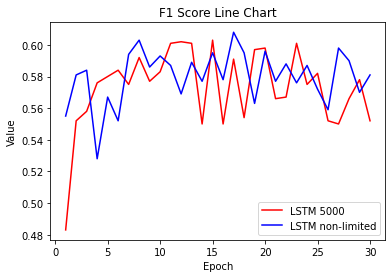

In [132]:
import matplotlib.pyplot as plt

# x-axis data
x = [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

# different coloured folds
y1 = LSTM_5000_F1_score
y2 = LSTM_nonlimited_F1_list

# Draw line graphs
plt.plot(x, y1, color='red', label='LSTM 5000')
plt.plot(x, y2, color='blue', label='LSTM non-limited')

# Add captions, labels and legends
plt.title('F1 Score Line Chart')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()

plt.show()

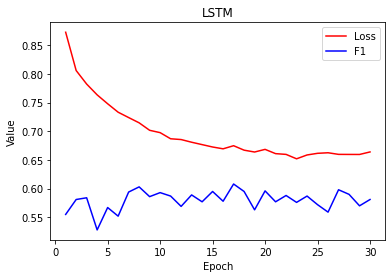

In [133]:
x = [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
# y1 = LSTM_nonlimited_F1_list
y2 = LSTM_nonlimited_F1_list
y1=LSTM_nonlimited_loss_list

# Draw line graphs
plt.plot(x, y1, color='red', label='Loss')
plt.plot(x, y2, color='blue', label='F1')

# Add captions, labels and legends
plt.title('LSTM')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()

plt.show()

#### Build sentiment classifiers
You need to create your own classifiers (at least 3 classifiers). For each classifier, you can choose between the bag-of-word features and the word-embedding-based features. Each classifier has to be evaluated over 3 test sets. Make sure your classifier produce consistent performance across the test sets. Marking will be based on the performance over **all 5 test sets**(2 of them are not provided to you).

In [138]:
def get_BernoulliNB_preprocess(path):
    data=read_data(path)
    data,_=pre_process(data)
    dataset_preprocessed_new = [' '.join(text) for text in data]
    X = vectorizer.fit_transform(dataset_preprocessed_new)
    return X
def get_embedding_input(dataset):
    devset_preprocessed,_ = pre_process(dataset)
    dataset_label_LSTM=get_dataset_label_LSTM(dataset)
    dataset_LSTM =preprocess_data_test(devset_preprocessed,tokenizer)
    dev_dataset = torch.utils.data.TensorDataset(dataset_LSTM, dataset_label_LSTM)
    dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=4, shuffle=False)
    return dev_dataloader

In [137]:
# Buid traditional sentiment classifiers. An example classifier name 'svm' is given
# in the code below. You should replace the other two classifier names
# with your own choices. For features used for classifier training, 
# the 'bow' feature is given in the code. But you could also explore the 
# use of other features.
for classifier in ['SVM', 'BernoulliNB',"LSTM", 'GRU']:
    for features in ['bow', '<feature-2-name>']:
        model = None
        # Skeleton: Creation and training of the classifiers
        if classifier == 'SVM':
            # write the svm classifier here
            print('Training ' + classifier)
            with open('./model/SVC_model.pkl', 'rb') as f:
                model = pickle.load(f)
        elif classifier == 'BernoulliNB':
            # write the classifier 2 here
            print('Training ' + classifier)
            model = BernoulliNB(alpha= 10.0, class_prior= None, fit_prior= True)
            model.fit(X_1000, train_label)
        elif classifier == 'LSTM':
            # write the classifier 3 here
            print('Training ' + classifier)
            model = SentimentAnalysisModel(embedding_matrix,hidden_dum)
            model.load_state_dict(torch.load('./model/best_lstm_500015.pth'))
        elif classifier == 'GRU':
            # write the LSTM classifier here
            print('Training ' + classifier)
            model = SentimentAnalysisTransferModel(embedding_matrix,hidden_dum,bidirectional,n_layers,dropout)
            # 5000*100
            model.load_state_dict(torch.load('./model/best_transformer_5.pth'))

        # Predition performance of the classifiers
        for testset in testsets:
            id_preds = {}
            testset_name = testset
            test_tf=get_BernoulliNB_preprocess(testset_name)
            testset=read_data(testset)
            test_embedding_input=get_embedding_input(testset)
            if classifier == 'SVM':
                id_preds=get_SVC_result(model,test_tf,testset)
            elif classifier == 'BernoulliNB':
                get_BernoulliNB_result(model,test_tf,testset,testset_name)
            elif classifier == 'LSTM':
                    dev_result=[]
                    with torch.no_grad():
                        for inputs, labels in test_embedding_input:
                            outputs = model(inputs)
                            _, predicted = torch.max(outputs.data, 1)
                            total += labels.size(0)
                            dev_result=dev_result+predicted.tolist()
                            correct += (predicted == labels).sum().item()
                    id_preds=get_LSTM_result(model,test_tf,testset)
            elif classifier == 'GRU':
                dev_result=[]
                with torch.no_grad():
                    for inputs, labels in test_embedding_input:
                        outputs = model(inputs)
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        dev_result=dev_result+predicted.tolist()
                        correct += (predicted == labels).sum().item()
                id_preds=get_LSTM_result(model,test_tf,testset)
            testset_path = join(testset_name)
            evaluate(id_preds, testset_path, features + '-' + classifier)